In [1]:
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def compute_log_log_graph(ww2, ww1, sw, tag, name):
    cluster_sizes = np.array(list(map(lambda c: c.address_count(), arr)))
    bins = np.logspace(np.log10(cluster_sizes.min()), np.log10(cluster_sizes.max()), num=50)
    hist, bin_edges = np.histogram(cluster_sizes, bins=bins)
    hist = np.where(hist == 0, np.nan, hist)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, hist, marker='o')
    plt.xscale('log')
    plt.yscale('log')    
    plt.title(name)
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.savefig(f"/mnt/blocksci/{tag}.png")
    plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_cluster_graph(ww1, ww2, sw):
    sizes_ww1 = [cluster.address_count() for cluster in ww1]
    sizes_ww2 = [cluster.address_count() for cluster in ww2]
    sizes_sw = [cluster.address_count() for cluster in sw]
    
    df_ww1 = pd.DataFrame({'size': sizes_ww1})
    df_ww1['coordinator'] = 'Wasabi Wallet 1'
    
    df_ww2 = pd.DataFrame({'size': sizes_ww2})
    df_ww2['coordinator'] = 'Wasabi Wallet 2'
    
    df_sw = pd.DataFrame({'size': sizes_sw})
    df_sw['coordinator'] = 'Samourai Whirlpool'

    df_all = pd.concat([df_ww1, df_ww2, df_sw], ignore_index=True)
    
    # Sort the sizes in descending order for each coordinator
    df_all_sorted = df_all.groupby('coordinator').apply(lambda x: x.sort_values('size', ascending=False)).reset_index(drop=True)
    
    # Add a rank column for plotting
    df_all_sorted['rank'] = df_all_sorted.groupby('coordinator').cumcount() + 1
    
    # Plot the size vs. rank for each coordinator on a log-log scale
    plt.figure(figsize=(10, 6))
    
    for name, group in df_all_sorted.groupby('coordinator'):
        plt.plot(group['rank'], group['size'], label=name)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cluster Size')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.title('Cluster Sizes for Coinjoin Coordinators')
    plt.legend()
    plt.savefig("/mnt/blocksci/all_clusters.png")
    plt.show()


# Wasabi2 clusters

In [6]:
start = 0
stop = get_block_height_for_date('2024-10-31')

heuristic = blocksci.heuristics.coinjoin.input_one_hop \
    and blocksci.heuristics.coinjoin.output_three_hop_threshold \
    and blocksci.heuristics.coinjoin.output_two_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop \
    and blocksci.heuristics.coinjoin.output_one_hop_with_change

%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/wasabi2_out_threshold_change2/", \
    overwrite=True, \
    coinjoin_type="wasabi2", \
    heuristicFunc=heuristic \
)


Collected 16759406 addresses
Creating disjoint sets of size 16759406
Created disjoint sets of size 16759406
Preparing to serialize cluster data
Serializing cluster data
Serialized
CPU times: user 4min, sys: 19.3 s, total: 4min 20s
Wall time: 1min 15s


In [24]:
ww2_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_out_threshold_change2/", chain)
%time ww2_clusters = [cluster for cluster in ww2_clusterer.clusters() if cluster.address_count() > 1]
%time ww2_clusters_full = [cluster for cluster in ww2_clusterer.clusters()]
print("full", len(ww2_clusters_full))
print("filtered", len(ww2_clusters))

CPU times: user 10.7 s, sys: 61.9 ms, total: 10.8 s
Wall time: 10.8 s
CPU times: user 5.3 s, sys: 813 ms, total: 6.12 s
Wall time: 6.14 s
full 16279501
filtered 149160


# Whirlpool clusters
`9ea3e5d217c76e6be6ace7fe4fb3622976103466de81d2b02cd87c54f9e91a2f` should have 21 clustered addresses by the simple one output heuristics
`00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058` should have 567 addresses clustered

In [5]:
one_random_wp_cj = chain.tx_with_hash("9ea3e5d217c76e6be6ace7fe4fb3622976103466de81d2b02cd87c54f9e91a2f")
one_random_wp_cj = chain.tx_with_hash("00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058")
one_random_wp_cj = chain.tx_with_hash("021dc91d5d9d74babeed5dbf12a6287cbc4a46317afa357b45c46776940cf902")
address_im_looking_for = one_random_wp_cj.outputs[1].spending_tx.outputs[0].address

start = one_random_wp_cj.block_height
stop = one_random_wp_cj.block_height + 91302

start = 0
stop = get_block_height_for_date('2024-10-31')

heuristic = blocksci.heuristics.coinjoin.output_three_hop_threshold \
    and blocksci.heuristics.coinjoin.output_two_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop \
    and blocksci.heuristics.coinjoin.output_one_hop_with_change


# clusterer = blocksci.cluster.ClusterManager(str(cluster_directory / "fr"), chain)

%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/whirlpool_out_threshold_change_no_input/", \
    overwrite=True, \
    coinjoin_type="whirlpool", \
    heuristicFunc=heuristic, \
)


Collected 5138453 addresses
Creating disjoint sets of size 5138453
Created disjoint sets of size 5138453
Preparing to serialize cluster data
Serializing cluster data
Serialized
CPU times: user 9min 52s, sys: 18 s, total: 10min 9s
Wall time: 36 s


In [8]:
wp_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_out_threshold_change/", chain)
%time wp_clusters = [cluster for cluster in wp_clusterer.clusters()]
print(len(wp_clusters))
#compute_log_log_graph(wp_clusters)

CPU times: user 1.83 s, sys: 272 ms, total: 2.1 s
Wall time: 2.1 s
4809477


In [27]:
wp_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_out_threshold_change/", chain)
%time wp_clusters = [cluster for cluster in wp_clusterer.clusters() if cluster.address_count() > 1]
print(len(wp_clusters))
#compute_log_log_graph(wp_clusters, "wp_clusters_1", "Whirlpool Cluster sizes")

CPU times: user 3.14 s, sys: 207 ms, total: 3.34 s
Wall time: 3.36 s
30938


# Wasabi1 clustering


In [7]:
# import random

# one_random_wp_cj = chain.tx_with_hash("9ea3e5d217c76e6be6ace7fe4fb3622976103466de81d2b02cd87c54f9e91a2f")
# one_random_wp_cj = chain.tx_with_hash("00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058")
#address_im_looking_for = one_random_wp_cj.outputs[1].spending_tx.outputs[0].address
# print(address_im_looking_for) 10213510

start = one_random_wp_cj.block_height
stop = one_random_wp_cj.block_height + 1

start = 0
stop = get_block_height_for_date('2024-10-31')


heuristic = blocksci.heuristics.coinjoin.input_one_hop \
    and blocksci.heuristics.coinjoin.output_three_hop_threshold \
    and blocksci.heuristics.coinjoin.output_two_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop_threshold \
    and blocksci.heuristics.coinjoin.output_one_hop \
    and blocksci.heuristics.coinjoin.output_one_hop_with_change



%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/wasabi1_out_threshold_change2/", \
    overwrite=True, \
    coinjoin_type="wasabi1", \
    heuristicFunc=heuristic, \
)


Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
Serializing cluster data
Serialized
CPU times: user 4min 56s, sys: 17.3 s, total: 5min 13s
Wall time: 58 s


In [29]:
ww1_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_out_threshold_change2/", chain)
%time ww1_clusters = [cluster for cluster in ww1_clusterer.clusters() if cluster.address_count() > 1]
%time ww1_clusters_full = [cluster for cluster in ww1_clusterer.clusters()]
print("full", len(ww1_clusters_full))
print("filtered", len(ww1_clusters))

#compute_log_log_graph(ww1_clusters, "ww1_clusters_1", "WW1 Cluster sizes")

CPU times: user 5.84 s, sys: 36.9 ms, total: 5.88 s
Wall time: 5.91 s
CPU times: user 4.67 s, sys: 1.01 s, total: 5.68 s
Wall time: 5.7 s
full 9901812
filtered 96373


## No clusters
not working yet :c

In [ ]:
start = 0
stop = get_block_height_for_date('2024-10-31')

heu = blocksci.heuristics.coinjoin.input_one_hop
heu = heu and blocksci.heuristics.coinjoin.output_three_hop_threshold
heu = heu and blocksci.heuristics.coinjoin.output_two_hop_threshold 
heu = heu and blocksci.heuristics.coinjoin.output_one_hop
heu = heu and blocksci.heuristics.coinjoin.output_one_hop_with_change


no_clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering( \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/no_cj_out_threshold_change/", \
    overwrite=True, \
    coinjoin_type=blocksci.CoinJoinType.NoCJ, \
    heuristicFunc=heu, \
)

In [ ]:
no_cj_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/no_cj_out_threshold_change/", chain)
%time no_cj_clusters = [cluster for cluster in no_cj_clusterer.clusters() if cluster.address_count() > 1]

## Results

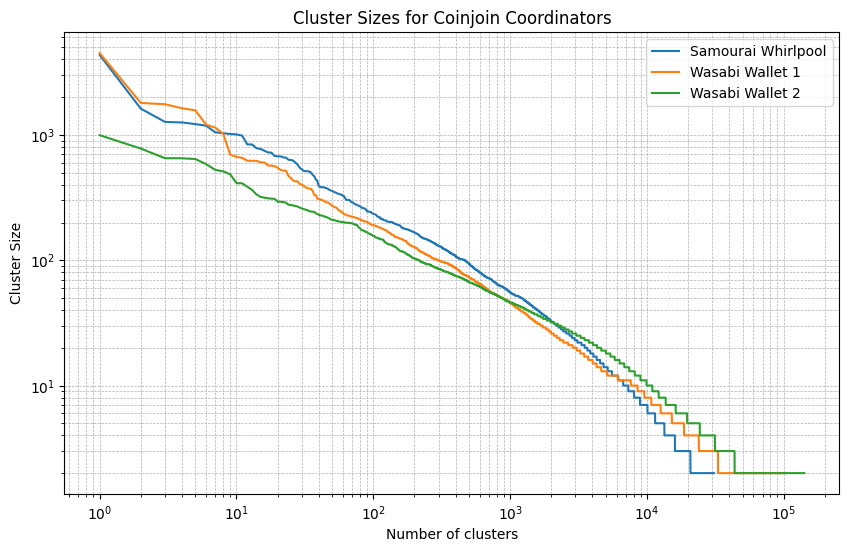

In [7]:
compute_cluster_graph(ww1_clusters, ww2_clusters, wp_clusters)

# Other cluster statistics

In [10]:
ww1_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_out_threshold_change2/", chain)
wp_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_out_threshold_change_no_input/", chain)
ww2_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_out_threshold_change2/", chain)

In [11]:
%time ww2_clusters = [cluster for cluster in ww2_clusterer.clusters() if cluster.address_count() > 1]
%time ww1_clusters = [cluster for cluster in ww1_clusterer.clusters() if cluster.address_count() > 1]
%time wp_clusters = [cluster for cluster in wp_clusterer.clusters() if cluster.address_count() > 1]


CPU times: user 10.1 s, sys: 2.49 s, total: 12.6 s
Wall time: 12.7 s
CPU times: user 6.23 s, sys: 1.21 s, total: 7.44 s
Wall time: 7.47 s
CPU times: user 2.89 s, sys: 197 ms, total: 3.09 s
Wall time: 3.1 s


In [12]:
from tabulate import tabulate

print(tabulate(
    [
        [
            "Wasabi Wallet 1", 
            10236857,
            len(ww1_clusters), 
            max(map(lambda c: c.address_count(), ww1_clusters))
        ],
        [
            "Wasabi Wallet 2", 
            15858241,
            len(ww2_clusters), 
            max(map(lambda c: c.address_count(), ww2_clusters))
        ],
        [
            "Samourai Whirlpool", 
            5135482,
            len(wp_clusters), 
            max(map(lambda c: c.address_count(), wp_clusters))
        ],
        
    ],
    headers=['Pool', "Total addresses collected", "Number of clusters", "Biggest cluster size"], 
    tablefmt='orgtbl'
    )
)


| Pool               |   Total addresses collected |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10236857 |                96373 |                   2620 |
| Wasabi Wallet 2    |                    15858241 |               149160 |                    628 |
| Samourai Whirlpool |                     5135482 |                30938 |                   4344 |


In [23]:
def plot_biggest_clusters(ww1, ww2, sw):

    def process(biggest_cluster):
        a: blocksci.Address
        
        all_cluster_transactions = set()
        
        for a in biggest_cluster.addresses.to_list():
            for tx in a.txes:
                all_cluster_transactions.add(tx)
        
        
        df_cluster = pd.DataFrame([(tx.block_time, 1) for tx in all_cluster_transactions], columns=["time", "count"])
        df_cluster["week_start"] = df_cluster["time"].dt.to_period("W").apply(lambda r: r.start_time)
        weekly_cluster = df_cluster.groupby("week_start")["count"].sum().reset_index()
        return weekly_cluster

    df_ww1 = process(ww1)
    df_ww2 = process(ww2)
    df_sw = process(sw)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_ww1['week_start'], df_ww1["count"], label="WW1")
    plt.plot(df_ww2['week_start'], df_ww2["count"], label="WW2")
    plt.plot(df_sw['week_start'], df_sw["count"], label="Whirlpool")
    plt.grid(ls='--')
    plt.xlabel('Time')
    plt.ylabel('Transaction count')
    plt.title('Number of transactions in the biggest clusters')
    plt.legend()

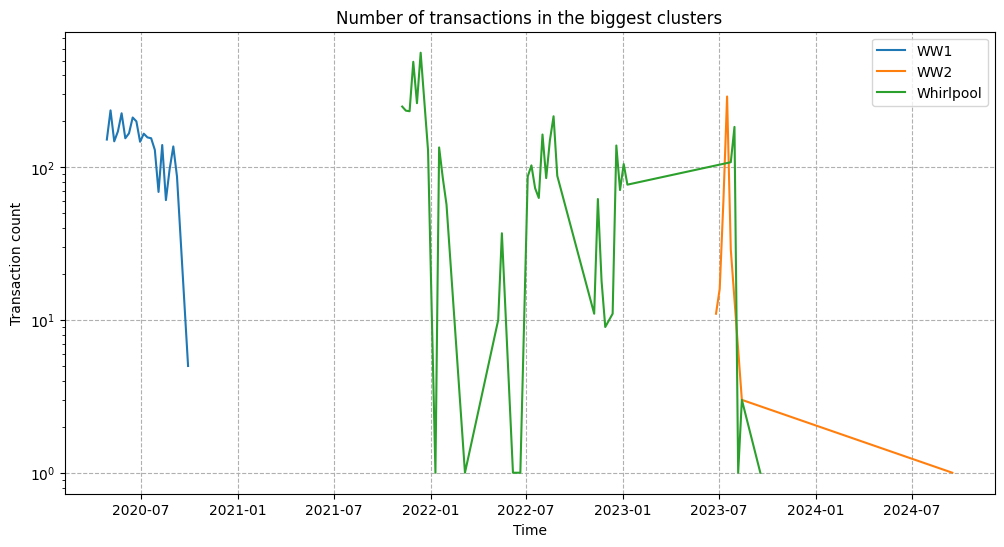

In [22]:
plot_biggest_clusters(max(ww1_clusters, key=lambda c: c.address_count()), max(ww2_clusters, key=lambda c: c.address_count()), max(wp_clusters, key=lambda c: c.address_count()))

In [53]:
coordinator_cluster = ww1_clusterer.cluster_with_address(chain.address_from_string("bc1qs604c7jv6amk4cxqlnvuxv26hv3e48cds4m0ew"))

for address in coordinator_cluster.addresses.to_list():
    print(address)
    print(len(list(address.txes)))

ScriptHashAddress(3CuEa41MFzuKF7Vs48L9Yh89nD3CXqw51M, wrapped_address=bc1qpwy023faymtq5kallwrey0fv2zhrmucavww287)
2
bc1qs604c7jv6amk4cxqlnvuxv26hv3e48cds4m0ew
5373
bc1q7efa80squh3w6g7hdt292kky4j5j64ah262fzg
2
bc1q7dc06php6fyxtk7yh9dd0a2f5cau0zly2wtc6z
2


In [18]:
ww1_biggest_cluster = max(ww1_clusters, key=lambda c: c.address_count())
ww2_biggest_cluster = max(ww2_clusters, key=lambda c: c.address_count())
wp_biggest_cluster = max(wp_clusters, key=lambda c: c.address_count())

print(next(iter(ww1_biggest_cluster.addresses.to_list())))
print(next(iter(ww2_biggest_cluster.addresses.to_list())))
print(next(iter(wp_biggest_cluster.addresses.to_list())))

bc1qg5jtuu7rms3cgkwuhqwvdqm2vxkfcz5ya9jplz
bc1qt4u53hwjqxfvsndjjxzxxaghj20a7329e8sr8m
ScriptHashAddress(3J8pKBNnp6rxy6UaXxJiPixbDrtUaNmF2C, wrapped_address=bc1q2k7cvvetvd6zl8reg0y2zjyzld9mgzgsa5kdv5)
